In [ ]:
os.makedirs('/fault_detection/drive', exist_ok=True)

from google.colab import drive
drive.mount('/fault_detection/drive')

Mounted at /fault_detection/drive


In [ ]:
import os

Loading data from: /fault_detection/drive/MyDrive/fault_detection/DataLine1.csv
Engineering Features...
Inputs separated. Continuous features: 16, Fault Types: 4
Starting training with Mixture of Experts...
Epoch 1/1500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2557 - mae: 0.4196 - val_loss: 0.1085 - val_mae: 0.4154 - learning_rate: 0.0010
Epoch 2/1500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0953 - mae: 0.2320 - val_loss: 0.1020 - val_mae: 0.3943 - learning_rate: 0.0010
Epoch 3/1500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0654 - mae: 0.1981 - val_loss: 0.0931 - val_mae: 0.3742 - learning_rate: 0.0010
Epoch 4/1500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0530 - mae: 0.1712 - val_loss: 0.0895 - val_mae: 0.3633 - learning_rate: 0.0010
Epoch 5/1500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0497 - mae: 0.1635 - val_loss: 0.0842 - val_mae: 0.3548 - learning_rate: 0.0010
Epoch 6/1500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0383 - mae: 0.13

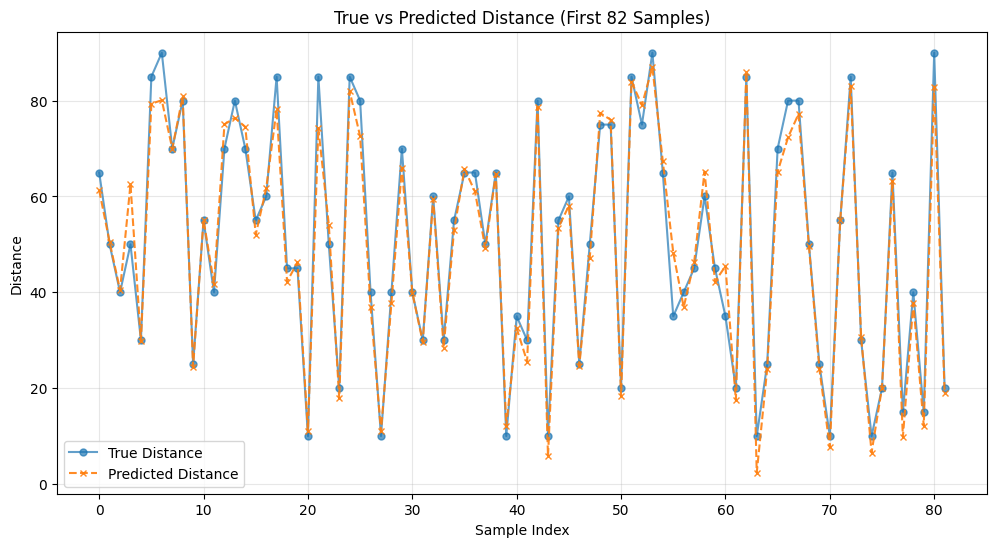

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os

# 1. SETUP & DATA LOADING
possible_paths = [
    "/fault_detection/drive/MyDrive/fault_detection/DataLine1.csv"
]

LineData = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"Loading data from: {path}")
        LineData = pd.read_csv(path)
        break


# 2. FEATURE ENGINEERING
def engineer_features(df):
    df_eng = df.copy()
    eps = 1e-6

    # 1. Log Transforms
    for col in ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']:
        df_eng[f'log_{col}'] = np.log1p(df_eng[col])

    # 2. Impedance Features (Z = V/I)
    df_eng['Za'] = df_eng['Va'] / (df_eng['Ia'] + eps)
    df_eng['Zb'] = df_eng['Vb'] / (df_eng['Ib'] + eps)
    df_eng['Zc'] = df_eng['Vc'] / (df_eng['Ic'] + eps)

    # 3. Power Features (S = V*I)
    df_eng['Sa'] = df_eng['Va'] * df_eng['Ia']
    df_eng['Sb'] = df_eng['Vb'] * df_eng['Ib']
    df_eng['Sc'] = df_eng['Vc'] * df_eng['Ic']

    # 4. Statistical Imbalance
    df_eng['I_std'] = df_eng[['Ia', 'Ib', 'Ic']].std(axis=1)
    df_eng['V_std'] = df_eng[['Va', 'Vb', 'Vc']].std(axis=1)

    # 5. Imbalance Ratios (New)
    currents = df_eng[['Ia', 'Ib', 'Ic']].values
    voltages = df_eng[['Va', 'Vb', 'Vc']].values
    # Avoid div by zero with max(x, eps)
    df_eng['I_ratio'] = np.max(currents, axis=1) / (np.min(currents, axis=1) + eps)
    df_eng['V_ratio'] = np.max(voltages, axis=1) / (np.min(voltages, axis=1) + eps)

    return df_eng

print("Engineering Features...")
LineData = engineer_features(LineData)

# Shuffle
LineData_suffled = shuffle(LineData, random_state=42)

# 3. SEPARATE INPUTS (CONTINUOUS vs FAULT TYPES)


continuous_features = [
    "log_Ia", "log_Ib", "log_Ic",
    "log_Va", "log_Vb", "log_Vc",
    "Za", "Zb", "Zc",
    "Sa", "Sb", "Sc",
    "I_std", "V_std",
    "I_ratio", "V_ratio"
]

# These act as the "Gate" or "Switch"
fault_type_features = ["LG", "LL", "LLG", "LLL"]

target_col = ["Distance"]

X_cont = LineData_suffled[continuous_features].values
X_type = LineData_suffled[fault_type_features].values
Y = LineData_suffled[target_col].values

# 4. PREPROCESSING & SPLIT
scaler_x = StandardScaler()
X_cont_scaled = scaler_x.fit_transform(X_cont)

scaler_y = MinMaxScaler(feature_range=(0, 1))
Y_scaled = scaler_y.fit_transform(Y)

# We need to split both input arrays (Continuous and Type) and the target
# We stack them temporarily to split, then unstack
X_combined = np.hstack([X_cont_scaled, X_type])

y_bins = pd.cut(Y.flatten(), bins=10, labels=False)

x_train_all, x_val_all, y_train, y_val = train_test_split(
    X_combined, Y_scaled,
    test_size=0.15,
    random_state=42,
    stratify=y_bins
)

# Unstack back into two inputs
num_cont = len(continuous_features)
x_train_cont = x_train_all[:, :num_cont]
x_train_type = x_train_all[:, num_cont:]

x_val_cont = x_val_all[:, :num_cont]
x_val_type = x_val_all[:, num_cont:]

# Sample Weights (Aggressive edge weighting)
y_train_flat = y_train.flatten()
# Higher weight (10.0) for edges to fix the min/max issue
sample_weights = 1.0 + 10.0 * ((y_train_flat - 0.5) ** 2)

print(f"Inputs separated. Continuous features: {num_cont}, Fault Types: 4")

# 5. MIXTURE OF EXPERTS (MoE) ARCHITECTURE
def build_expert_model(cont_input_shape, type_input_shape):

    # Input 1: Continuous Signals (Voltage, Current, Impedance)
    input_cont = keras.Input(shape=cont_input_shape, name="continuous_input")

    # Input 2: Fault Type (The Gating Signal)
    input_type = keras.Input(shape=type_input_shape, name="fault_type_input")

    # Learns common patterns relevant to all faults
    shared = layers.Dense(128, activation='swish')(input_cont)
    shared = layers.BatchNormalization()(shared)


    # Expert 1: LG Faults
    exp1 = layers.Dense(64, activation='swish')(shared)
    exp1 = layers.Dense(32, activation='swish')(exp1)
    out1 = layers.Dense(1, activation='linear', name="pred_LG")(exp1)

    # Expert 2: LL Faults
    exp2 = layers.Dense(64, activation='swish')(shared)
    exp2 = layers.Dense(32, activation='swish')(exp2)
    out2 = layers.Dense(1, activation='linear', name="pred_LL")(exp2)

    # Expert 3: LLG Faults
    exp3 = layers.Dense(64, activation='swish')(shared)
    exp3 = layers.Dense(32, activation='swish')(exp3)
    out3 = layers.Dense(1, activation='linear', name="pred_LLG")(exp3)

    # Expert 4: LLL Faults
    exp4 = layers.Dense(64, activation='swish')(shared)
    exp4 = layers.Dense(32, activation='swish')(exp4)
    out4 = layers.Dense(1, activation='linear', name="pred_LLL")(exp4)

    # GATING / SWITCHING MECHANISM

    # Assuming order: LG, LL, LLG, LLL
    flag_lg = layers.Lambda(lambda x: x[:, 0:1])(input_type)
    flag_ll = layers.Lambda(lambda x: x[:, 1:2])(input_type)
    flag_llg = layers.Lambda(lambda x: x[:, 2:3])(input_type)
    flag_lll = layers.Lambda(lambda x: x[:, 3:4])(input_type)

    # Weighted Sum
    final_output = layers.Add()([
        layers.Multiply()([out1, flag_lg]),
        layers.Multiply()([out2, flag_ll]),
        layers.Multiply()([out3, flag_llg]),
        layers.Multiply()([out4, flag_lll])
    ])

    # Robustness: Add a bias term in case all flags are 0 (though unlikely in dataset)
    final_output = layers.Dense(1, activation='linear')(final_output)

    return Model(inputs=[input_cont, input_type], outputs=final_output)

model = build_expert_model((num_cont,), (4,))

# Optimizer & Loss
optimizer = keras.optimizers.Nadam(learning_rate=0.001)

# LogCosh is smoother than MAE and handles outliers better than MSE
model.compile(
    optimizer=optimizer,
    loss='log_cosh',
    metrics=['mae']
)

# 6. TRAINING
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00005,
    patience=40,
    restore_best_weights=True,
    monitor='val_loss'
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001
)

print("Starting training with Mixture of Experts...")

# We must pass inputs as a list: [continuous, types]
history = model.fit(
    [x_train_cont, x_train_type], y_train,
    validation_data=([x_val_cont, x_val_type], y_val),
    sample_weight=sample_weights,
    batch_size=32,
    epochs=400,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 7. EVALUATION
y_pred_scaled = model.predict([x_val_cont, x_val_type])
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled)
y_val_actual = scaler_y.inverse_transform(y_val)

mae = np.mean(np.abs(y_val_actual - y_pred_actual))
print(f"\nFinal Mean Absolute Error: {mae:.4f} (Distance units)")

# Plot Results
y_true = np.array(y_val_actual).reshape(-1)
y_pred = np.array(y_pred_actual).reshape(-1)

plt.figure(figsize=(12, 6))
limit = 100 if len(y_true) > 100 else len(y_true)
# Using scatter plot style for better clarity
plt.plot(y_true[:limit], label='True Distance', color='#1f77b4', marker='o', markersize=5, alpha=0.7)
plt.plot(y_pred[:limit], label='Predicted Distance', color='#ff7f0e', linestyle='--', marker='x', markersize=5, alpha=0.9)
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.title(f"True vs Predicted Distance (First {limit} Samples)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()